In [53]:
import sys
sys.path.append("/Users/Tanay/Desktop/CS269I/agentmodel/PyLOB/")

import math
from random import randint
from numpy.random import normal
from collections import defaultdict, OrderedDict
from PyLOB import OrderBook
import matplotlib.pyplot as plt
import numpy as np

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def biased_coin(prob):
    return int(np.random.random() < prob)

In [55]:
def clamp_bas_price(price):
    # 1 BAS = price ETH
    return np.clip(price, 0, 10.0)

def clamp_bas_qty(qty): 
    # Max order size of $100,000
    return int(np.clip(qty, 0, 1e5))

In [56]:
class Protocol:
    def __init__(self, totalSupply):
        self.totalSupply = totalSupply
        
class BasisProtocol(Protocol):
    pass

In [88]:
class Trader: 
    def __init__(self, tid, protocol, market):
        self.tid = tid
        self.protocol = protocol
        self.market = market
        self.portfolioRatio = 0.5
        self.eth = 10
        self.bas = 1000
        
    def getIdealValue(self):
        return self.eth * 100 + self.bas

    def marketStep(self):
        return None
    
'''
    IdealTrader buys/sells according to market demand. 
    Sets prices to be around the ideal exchange rate ~ 0.01.
'''
class IdealTrader(Trader):
    def __init__(self, tid, protocol, market):
        super().__init__(tid, protocol, market)
        self.bas = 100000 # $100,000 in BASIS 
        self.portfolioRatio = 0.01
        
    def marketStep(self):
        BASE_PRICE = self.market.usd_eth # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread

        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(self.market.demandRatio)]
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 0.0002)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)
        
        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = int(normal(qty_mu, qty_sigma) * self.bas)
        qty = clamp_bas_qty(qty)

        if qty <= 0:
            return None
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order
    
class RandomTrader(Trader): 
    def __init__(self, key, protocol, market):
        super().__init__(key, protocol, market)
        self.portfolioRatio = 0.05
        self.bas = 10000
        
    def marketStep(self):
        BASE_PRICE = self.market.getCurrentValue() # Assuming 1 ETH = $100
        BASE_SPREAD = 1e-3 # 0.10% spread

        # Randomly select bid / ask based on market demand
        side = ['bid', 'ask'][biased_coin(self.market.demandRatio)]
        
        # Set price around BASE_PRICE
        price = normal(BASE_PRICE, 0.0001)
        if side == 'bid':
            price -= (BASE_PRICE * BASE_SPREAD) 
        else:
            price += (BASE_PRICE * BASE_SPREAD) 
        price = clamp_bas_price(price)

        # Set Quantity around portfolio ratio 
        qty_mu = self.portfolioRatio
        qty_sigma = qty_mu * 0.1
        qty = int(normal(qty_mu, qty_sigma) * self.bas)
        qty = clamp_bas_qty(qty)

        if qty <= 0:
            return None
        
        order = {'type': 'limit', 'price': price, 'tid': self.tid, 'side': side, 'qty': qty}
        return order

class TrendMaker(Trader):
    pass

class BuyFDeeps(Trader):
    pass

class BasicTrader(Trader): 
    pass

class OracleSpeculator(Trader): 
    pass

class ArbitrageUpTrader(Trader):
    pass

class ArbitrageDownTrader(Trader):
    pass

trader_dict = {'IdealTrader': IdealTrader, 'RandomTrader': RandomTrader, 'TrendMaker': TrendMaker, 
               'BuyFDeeps': BuyFDeeps,'BasicTrader': BasicTrader, 'OracleSpeculator': OracleSpeculator, 
               'ArbitrageUpTrader': ArbitrageUpTrader, 'ArbitrageDownTrader': ArbitrageDownTrader}


In [89]:
def createTraderPool(protocol, market, demographics):
    traderPool = {}
    uniqTID = 1
    for trader_type, number in demographics.items():
        trader_class = trader_dict[trader_type]
        for i in range(number):
            trader = trader_class(uniqTID, protocol, market)
            traderPool[uniqTID] = trader
            uniqTID += 1
    return traderPool

In [90]:
class Market:
    def __init__(self):
        self.demandRatio = 0.5 # in [0, 1]
        
        # ETH Trades
        self.usd_eth = 0.01
        self.bas_eth = 0.01
        
        self.orderbook = OrderBook(tick_size=0.0001)
        self.traderPool = {}
        
        self.prices = defaultdict(list)
        
    def setTraderPool(self, traderPool):
        self.traderPool = traderPool
        self.orderbook.setTraderPool(traderPool)
        
    def getCurrentValue(self, func_type='avg_edge_bidask'):
        def avg_bidask():
            return (self.orderbook.getBestBid() + self.orderbook.getBestAsk()) / 2
        
        def wavg_bidask():
            bid_price, ask_price = self.orderbook.getBestBid(), self.orderbook.getBestAsk()
            bid_vol = self.orderbook.getVolumeAtPrice('bid', bid_price)
            ask_vol = self.orderbook.getVolumeAtPrice('ask', ask_price)
            total_vol = bid_vol + ask_vol
            return (bid_price * bid_vol + ask_price * ask_vol) / total_vol
        
        if self.orderbook.getBestBid() is None or self.orderbook.getBestAsk() is None:
            if self.orderbook.getBestBid() is not None:
                return self.orderbook.getBestBid()
            elif self.orderbook.getBestAsk() is not None: 
                return self.orderbook.getBestBid()
            else:
                return self.bas_eth
        
        func_list = {'avg_edge_bidask': avg_bidask, 'wavg_edge_bidask': wavg_bidask}
        
        return func_list[func_type]()
        
    def processOrder(self, quote):
        trades, idNum = self.orderbook.processOrder(quote, False, False)
        for func in ['avg_edge_bidask', 'wavg_edge_bidask']:
            self.prices[func].append(self.getCurrentValue(func))
            
        return trades, idNum

In [91]:
trader_demographics = OrderedDict()
trader_demographics['IdealTrader'] = 5
trader_demographics['RandomTrader'] = 100

In [92]:
basis = BasisProtocol(int(1e6))
market = Market()
traderPool = createTraderPool(basis, market, trader_demographics)
market.setTraderPool(traderPool)

In [93]:
initialOrders = []
NUM_ORDERS = 2000
NUM_TRADERS = trader_demographics['IdealTrader'] # We initially set it up with randomTraders

for _ in range(NUM_ORDERS):
    tid = randint(1, NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order:
        initialOrders.append(order)
    
for i, order in enumerate(initialOrders):
    trades, idNum = market.processOrder(order)

In [94]:
def bin_data(data, bin_size):
    valid_length = (data.shape[0] // bin_size) * bin_size
    data = data[:valid_length]
    N = data.shape[0]
    binned = np.zeros(N // bin_size)
    for k in range(0, N, bin_size):
        binned[k // bin_size] = data[k : k + bin_size].mean()
    return binned

def plot_prices(market, price_func, bin_size=50, warmup=100): 
    data = np.array(market.prices[price_func])[warmup:]
    binned = bin_data(data, bin_size)
    
    # Currently in BAS/ETH. Need to convert to BAS/USD
    binned = binned / market.usd_eth
    ideal = np.ones(binned.shape)
    plt.plot(ideal, 'r')
    plt.plot(binned, 'b')
    plt.ylim(0.9, 1.1)

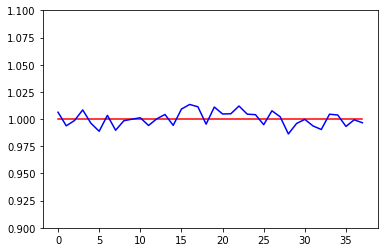

In [95]:
plot_prices(market, 'wavg_edge_bidask')

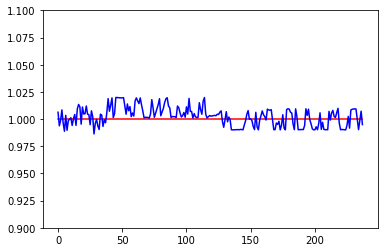

In [101]:
NUM_ORDERS_LIVE = 10000
NUM_TRADERS = trader_demographics['RandomTrader'] # We initially set it up with randomTraders

offset = trader_demographics['IdealTrader']
for _ in range(NUM_ORDERS):
    tid = randint(offset + 1, offset + NUM_TRADERS)
    order = traderPool[tid].marketStep()
    if order: 
        trades, idNum = market.processOrder(order)    
        
plot_prices(market, 'wavg_edge_bidask')

(array([ 100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.]),
 array([  10936.58 ,   19925.312,   28914.044,   37902.776,   46891.508,
          55880.24 ,   64868.972,   73857.704,   82846.436,   91835.168,
         100823.9  ]),
 <a list of 10 Patch objects>)

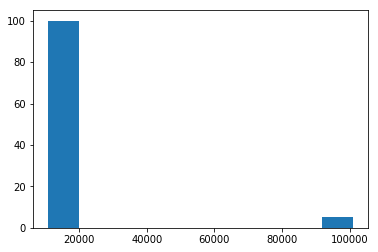

In [97]:
final_values = [trader.getIdealValue() for trader in traderPool.values()]
plt.hist(final_values, bins=10)